# Oscillations, Real Pendulums, and Chaos

In this section, we consider numerical solutions to the motion of a pendulum, which has two important differences compared to projectile motion. First, we will see that the inaccuracies that are inherent to an approximate scheme like the Euler method can render the solution to oscillatory problems *unstable* --- small errors accumulate in our solution. Second, when we consider real pendulums with dissipation and driving forces, we encounter the possibility of chaos --- an important feature in the study of real dynamical systems, which is quite difficult to study without computational approaches.

## A Simple Pendulum

Consider a simple pendulum as shown in the figure: ![pendulum](./pendulum.png) 
For now, the only two forces acting on the pendulum are gravity and the tension in the string. As I am sure John Morgan has told you, it is convenient to work in a coordinate system with one axis along the string and the other perpendicular. In this system, the only net force is perpendicular to the string, labeled $F_\theta$ in the figure:

$$F_\theta = -mg\text{sin}\theta$$

where $m$ is the mass of the pendulum bob and $g$ is the gravitational acceleration. This force has to equal the mass times the acceleration along the circular arc of the motion, which we denote by $s$:

$$m\frac{d^2s}{dt^2} = -mg\text{sin}\theta$$

The displacement along the arc when the pendulum moves through an angle $\theta$ is $s=\ell\theta$, where $\ell$ is the length of the string. Making the usual freshman mechanics assumption that $\theta$ is small, $\text{sin}\theta \approx \theta$:

$$\frac{d^2\theta}{dt^2} = -g\frac{\theta}{\ell}$$

The solution to this differential equation gives the sinusoidal motion of the pendulum:

$$\theta (t) = \theta_0\text{sin}(\omega_0t + \phi)$$

with the natural frequency given by $\omega_0 = \sqrt{g/\ell}$. Because there is no friction, this pendulum (which only exists in physics textbooks!) keeps going with the same amplitude and frequency forever. 

If we wish to solve the problem numerically, it is helpful to first rewrite as two first-order ODE's, just like we did for projectiles: 

$$\begin{align}
\frac{d\omega}{dt} & = -\frac{g}{\ell}\theta \\
\frac{d\theta}{dt} & = \omega\\
\end{align}$$

Writing an Euler algorithm for the solution:

$$\begin{align}
\omega_{i+1} = \omega_i - \frac{g}{\ell}\theta_i \Delta t \\
\theta_{i+i} = \theta_i + \omega_i \Delta t \\
\end{align}$$

**Normalization:** The natural frequency $\omega_0$ sets the timescale $t_0 = 1/\omega_0$. If measure time and frequency in these units our Euler algorithm simplifies to

$$\begin{align}
\omega_{i+1} = \omega_i - \theta_i \Delta t \\
\theta_{i+i} = \theta_i + \omega_i \Delta t \\
\end{align}$$

Let's see what happens when we implement this in code to solve for the position of the pendulum as a function of time. But first: 

**What do you expect a plot of $\mathbf{\theta}$ as a function of $\mathbf{t}$ to look like?**

In [ ]:
import matplotlib.pyplot as plt
import math as math

g = 9.81
L = 1
t0 = math.sqrt(L/g)
dt = 0.1
theta0 = 3.141593/4.0

theta = []
omega = []
time = []

theta.append(theta0)
omega.append(0.0)
time.append(0.0)

imax = 1000
for i in range (1,imax):
    theta_new = theta[i-1] + omega[i-1]*dt
    omega_new = omega[i-1] - theta[i-1]*dt
    t_new = i*dt
    
    theta.append(theta_new)
    omega.append(omega_new)
    time.append(t_new)

plt.plot(time,theta)
plt.xlabel('time')
plt.ylabel('$\\theta$')
plt.show()


**Questions:** Does this make sense? What should this plot look like? What is going on here? Maybe we need to use a smaller timestep?

Let's try decreasing $dt$ by a factor of $10$ (and also increasing the total number of timesteps by the same amount):

In [ ]:
dt = 0.01

theta = []
omega = []
time = []

theta.append(theta0)
omega.append(0.0)
time.append(0.0)

imax = 10000
for i in range (1,imax):
    theta_new = theta[i-1] + omega[i-1]*dt
    omega_new = omega[i-1] - theta[i-1]*dt
    t_new = i*dt
    
    theta.append(theta_new)
    omega.append(omega_new)
    time.append(t_new)

plt.plot(time,theta)
plt.xlabel('time')
plt.ylabel('$\\theta$')
plt.show()


What in tarnation?!? 

Let's take a look at some other observables and try and figure out what is going on. In particular, let's check and see whether energy is conserved, and also have a look at the phase plot. The energy of our system (in nondimensionalized form) is:

$$E = \frac{1}{2}\left( \frac{d\theta}{dt}\right)^2 + \frac{1}{2}\theta^2$$

Since this is a conservative system (no friction or damping of any kind), then we expect energy to be conserved. If we plot it as a function of time it should be flat, within numerical error.

The phase plot is a plot of position vs. (angular) velocity. Because this thing should oscillate forever, the phase plot should make a nice closed "orbit."

In [ ]:
dt = 0.1

theta = []
omega = []
time = []
energy = []

theta.append(theta0)
omega.append(0.0)
time.append(0.0)

E = 0.5*theta[0]**2 + 0.5*omega[0]**2

energy.append(E)

imax = 1000
for i in range (1,imax):
    theta_new = theta[i-1] + omega[i-1]*dt
    omega_new = omega[i-1] - theta[i-1]*dt
    t_new = i*dt
    
    E = 0.5*omega_new**2 + 0.5*theta_new**2
    
    theta.append(theta_new)
    omega.append(omega_new)
    energy.append(E)
    time.append(t_new)

plt.figure(1, figsize=(10, 3))
ax = plt.subplot(131)
ax.set_title('Ang. Displacement')
ax.set_xlabel('Time')
ax.set_ylabel('$\\theta$')
plt.plot(time,theta)

ax2 = plt.subplot(132)
plt.subplots_adjust(wspace=0.5)
ax2.set_title('Energy')
ax2.set_xlabel('Time')
ax2.set_ylabel('Energy')
plt.plot(time,energy)

ax3 = plt.subplot(133)
ax3.set_title('Phase plot')
ax3.set_xlabel('$\\theta$')
ax3.set_ylabel('$\omega$')
plt.plot(theta,omega)
plt.show()

Aha!! Notice that the energy appears to be *increasing* with time. This is clearly a mistake, as energy should be strictly conserved here. Let's take a look at what happens to the energy as we step through time in steps of size $\Delta t$ using the Euler method. Repeating the line above for the (dimensionless) energy of the pendulum: 

$$E = \frac{1}{2}\omega^2 + \frac{1}{2}\theta^2$$ 

And then rewriting in discretized form:

$$\begin{align}
E_{i+1} & = \frac{1}{2}\omega_{i+1}^2 + \frac{1}{2}\theta_{i+1}^2 \\
E_{i+1} & = \frac{1}{2}\left[\left(\omega_i - \theta_i\Delta t  \right)^2 + \left( \theta_i + \omega_i\Delta t \right)^2  \right] \\
E_{i+1} & = \frac{1}{2}\left(\omega_i^2 + \theta_i^2 \right) + \frac{1}{2}\left(\omega_i^2 + \theta_i^2 \right)\Delta t^2 \\
E_{i+1} & = E_i\left(1 + \Delta t^2 \right)
\end{align}$$

*The Euler method doesn't conserve energy for periodic systems!* So...we need a new algorithm. 

(For fun, you might use the above approach on the projectile problem integrated with Euler, and see what the error in the energy looks like.)

## Symplectic integrators: Euler-Cromer method

Consider the following modification of the Euler method:

$$\begin{align}
\omega_{i+1} = \omega_i - \theta_i \Delta t \\
\theta_{i+i} = \theta_i + \omega_{i+1} \Delta t \\
\end{align}$$

**Question:** The change is so slight, you might not even notice...where is it? 

Let's rewrite the $\theta$ equation in terms of "on-step" quantities only, for future use:

$$\begin{align}
\theta_{i+i} & = \theta_i + \omega_{i+1} \Delta t \\
 & = \theta_i +\left( \omega_i - \theta_i \Delta t \right)\Delta t \\
 & = \theta_i\left(1 - \Delta t^2  \right) + \omega_i\Delta t  \\
\end{align}$$


Why is this any better? Let's take a look at energy conservation with this modified algorithm:

$$\begin{align}
E_{i+1} & = \frac{1}{2}\omega_{i+1}^2 + \frac{1}{2}\theta_{i+1}^2 \\
    & = \frac{1}{2}\left[\left(\omega_i - \theta_i\Delta t  \right)^2 + \left( \theta_i\left(1 - \Delta t^2 \right) + \omega_i\Delta t \right)^2  \right] \\
    & = \frac{1}{2}\left[ \omega_i^2 + \theta_i^2 + \omega_i^2\Delta t^2 - \theta_i^2 \Delta t^2   \right] + \mathcal{O}(t^3) \\
    & = E_i + \frac{1}{2}\Delta t^2 \left(\omega_i^2 - \theta_i^2  \right) \\
\end{align}$$

Consider what happens with the additional energy as a function of time. Imagine we run the integrator for some time, using $\tau$ for time since we used $t$ in $\Delta t$. Then $\theta = \theta_0\text{sin}(\tau)$, then $\omega = \theta_0\text{cos}(\tau)$, and

$$\begin{align}
\omega_i^2 - \theta_i^2 & = \theta_0\left( \text{cos}^2(\tau) - \text{sin}^2(\tau)\right) \\
   & = \theta_0^2\text{cos}(2\tau)
\end{align}$$

Over each cycle, the error in the energy sums to zero! (Actually, it does this halfway through the cycle because of the factor of 2.) Notice that this only works here because we are considering oscillatory motion. When you encounter similar energy conservation artifacts for more general problems (classical molecular dynamics, e.g.), then you need to consider yet other algortihms with names like "Verlet," "Velocity Verlet," and "Leapfrog." This begs a question:

**Question:** Why bother with so many different ways to integrate an ODE? Or, what properties might we want an algorithm for solving Newton's equation to satisfy?

But, for now let's see if it works:



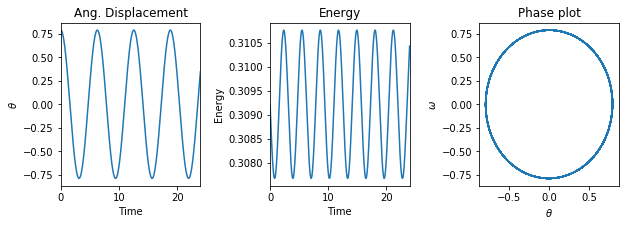

In [111]:
dt = 0.01

theta = []
omega = []
time = []
energy = []

#initial values
theta.append(theta0)
omega.append(0.0)
time.append(0.0)

# initial value of the energy
E = 0.5*theta[0]**2 + 0.5*omega[0]**2
energy.append(E)

# integrating for a total of imax timesteps
imax = 10000
for i in range (1,imax):
    
    #Euler-Cromer alg. note that the position is updated using the current velocity, not the 
    # last velocity
    omega_new = omega[i-1] - theta[i-1]*dt
    theta_new = theta[i-1] + omega_new*dt
    t_new = i*dt
    
    # total energy
    E = 0.5*omega_new**2 + 0.5*theta_new**2
    
    theta.append(theta_new)
    omega.append(omega_new)
    energy.append(E)
    time.append(t_new)

plt.figure(1, figsize=(10, 3))
plt.subplots_adjust(wspace=0.5)
ax = plt.subplot(131)
ax.set_title('Ang. Displacement')
ax.set_xlim(right=24)
ax.set_xlabel('Time')
ax.set_ylabel('$\\theta$')
plt.plot(time,theta)

ax2 = plt.subplot(132)
ax2.set_title('Energy')
ax2.set_xlim(right=24)
ax2.set_xlabel('Time')
ax2.set_ylabel('Energy')
plt.plot(time,energy)

ax3 = plt.subplot(133)
ax3.set_title('Phase plot')
ax3.set_xlabel('$\\theta$')
ax3.set_ylabel('$\omega$')
plt.plot(theta,omega)
plt.show()

## More interesting pendulums: Driving and dissipation

Real pendulums of course don't continue oscillating forever, but instead are subject to dissipation due to air resistance, friction, etc. Therefore a real pendulum must be given the occasional "kick" to keep it going. The combination of dissipation and driving will introduce the possibility of new physics, namely chaotic motion. (Later, we will see how to describe chaos mathematically.) And of course, there are plenty more examples in physics of harmonic systems subject to driving forces that arise in both classical and quantum systems.

The linearized (small angle) equation of motion for a damped pendulum is

$$\frac{d^2\theta}{dt^2} = -\frac{g}{\ell}\theta -q\frac{d\theta}{dt}$$

where we have assumed the damping to be proportional to velocity and the strength of the damping is given by $q$. This can be solved analytically (as I am sure you did in your classical mechanics course). Recall that the solutions decay, with a special value of $q$ that is called called "critical damping."

Let's take a look at how to solve this problem numerically. Of course, we need to use the Euler-Cromer method as we deal with oscillatory motion. The normalized equation of motion is:

$$\frac{d^2\theta}{dt^2} = -\theta -q\frac{d\theta}{dt}$$

where here we understand $q$ to be its normalized cousin $\bar{q}=t_oq$. We convert into two first order equations:

$$\begin{align}
\frac{d\theta}{dt} & = \omega \\
\frac{d\omega}{dt} & = -\theta - q\omega
\end{align}$$

Skipping the Euler algorithm and going straight to Euler-Cromer:

$$\begin{align}
\omega_{i+1} & = \omega_i - \left( \theta_i + q\omega_i\right )\Delta t \\
\theta_{i+i} & = \theta_i + \omega_{i+1} \Delta t \\
\end{align}$$

We will examine the behavior of our damped pendulum for values of the damping $q$ above and below critical damping $q_c$. I'll plot the critically damped case in orange. 

**Question:** What do you expect for $q<q_c$? What about $q>q_c$? Sketch the amplituide of oscillation as a function of time on a piece of paper for the three cases.

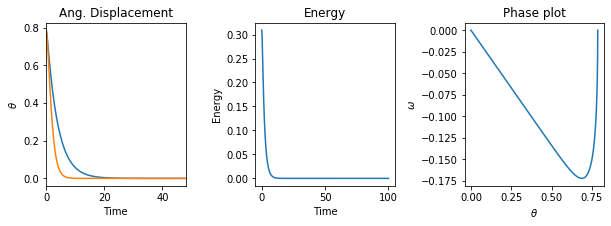

In [116]:
dt = 0.01
# I'll run this simultaneously for two different values of the damping constant. 
# critical damping at q_bar = 2
q1 = 4.0
q2 = 2.0


# theta and omega for damping q1
theta = []
omega = []

# theta and omega for damping q2
theta2 = []
omega2 = []
time = []

# only computing energy for the q1 case. should have called it "energy1" 
# to be consistent
energy = []

theta.append(theta0)
omega.append(0.0)
theta2.append(theta0)
omega2.append(0.0)
time.append(0.0)

E = 0.5*theta[0]**2 + 0.5*omega[0]**2
energy.append(E)

imax = 10000
for i in range (1,imax):
    #NOTICE! You have to compute velocity *first*, then position when using E-C.
    omega_new = omega[i-1] - (theta[i-1] + q1*omega[i-1])*dt
    theta_new = theta[i-1] + omega_new*dt
    t_new = i*dt
    
    E = 0.5*omega_new**2 + 0.5*theta_new**2
    # push the positions and velocities for the q1 case
    theta.append(theta_new)
    omega.append(omega_new)
    
    # now repeat for the q2 case
    omega_new = omega2[i-1] - (theta2[i-1] + q2*omega2[i-1])*dt
    theta_new = theta2[i-1] + omega_new*dt
    theta2.append(theta_new)
    omega2.append(omega_new)
    
    energy.append(E)
    time.append(t_new)

plt.figure(1, figsize=(10, 3))
plt.subplots_adjust(wspace=0.5)
ax = plt.subplot(131)
ax.set_title('Ang. Displacement')
ax.set_xlabel('Time')
ax.set_xlim(right=48)
ax.set_ylabel('$\\theta$')
plt.plot(time,theta)
plt.plot(time,theta2)

ax2 = plt.subplot(132)
ax2.set_title('Energy')
ax2.set_xlabel('Time')
ax2.set_ylabel('Energy')
plt.plot(time,energy)

ax3 = plt.subplot(133)
ax3.set_title('Phase plot')
ax3.set_xlabel('$\\theta$')
ax3.set_ylabel('$\omega$')
plt.plot(theta,omega)
plt.show()

Now let's add a term to the equation of motion to model the effect of a periodic driving force with angular frequency $\omega_D$:

$$\frac{d^2\theta}{dt^2} = -\frac{g}{\ell}\theta -q\frac{d\theta}{dt} + F_D\text{sin}\left(\omega_D t \right)$$

The (dimensionless) coupled first-order equations corresponding to the driven, damped oscillator are

$$\begin{align}
\frac{d\theta}{dt} & = \omega \\
\frac{d\omega}{dt} & = -\theta - q\omega +F_D\text{sin}\left(\omega_D t \right)
\end{align}$$

where now $q$, $F_D$, and $\omega_D$ are their dimensionless versions. The Euler-Cromer solution to this set of equations looks like

$$\begin{align}
\omega_{i+1} & = \omega_i - \left[ \theta_i + q\omega_i - F_D\text{sin}\left(\omega_D t \right) \right ]\Delta t \\
\theta_{i+i} & = \theta_i + \omega_{i+1} \Delta t \\
\end{align}$$

We have two new parameters to set: $F_D$ and $\omega_D$. $F_D$ is the amplitude/strength of the driving force, and $\omega_D$ is its frequency. 

**Question:** What happens if we drive the pendulum at a frequency less than its natural frequency? (That is, $\omega_D < \omega_0$.) What about $\omega_D > \omega_0$? What about $\omega_D = \omega_0$?

Let's have a look. I'll plot the driving term in orange in the first plot below. I'll set $q=0.1$...use the code cell above to check the period of oscillation for this case, so that you can compare to the period for the driven system. Change the xlim argument for the first plot to look at the first few cycles (xlim=24), then increase it to look at a larger number of cycles.

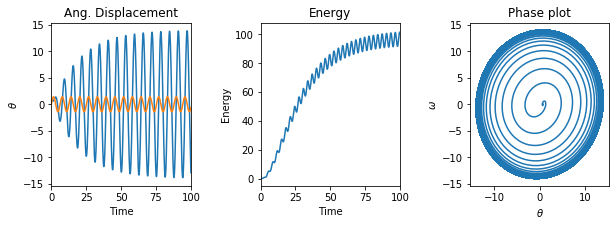

In [124]:
import numpy as np

dt = 0.1  # timestep
q = 0.1   # damping constant
F_D = 1.4 # amplitude of the forcing term
omega_D = 1.0 # frequency of the forcing term. start at 0.5, then 1.5, then match omega0 at 1.0


theta = []
omega = []
time = []
energy = []

theta.append(theta0)
omega.append(0.0)
time.append(0.0)

E = 0.5*theta[0]**2 + 0.5*omega[0]**2
energy.append(E)

imax = 10000
for i in range (1,imax):

    t_old = (i - 1)*dt
    t_new = i*dt
    omega_new = omega[i-1] - (theta[i-1] + q*omega[i-1] - F_D*math.sin(omega_D*t_old))*dt
    theta_new = theta[i-1] + omega_new*dt
  
    
    E = 0.5*omega_new**2 + 0.5*theta_new**2
    
    theta.append(theta_new)
    omega.append(omega_new)
    energy.append(E)
    time.append(t_new)

# the x,y series will ploty the driving term
x = np.linspace(0.0,200,1200)
y = F_D*np.sin(omega_D*x)
    
plt.figure(1, figsize=(10, 3))
plt.subplots_adjust(wspace=0.5)
ax = plt.subplot(131)
ax.set_title('Ang. Displacement')
#ax.set_xlim(right=1000)
#ax.set_xlim(left=48)
ax.set_xlim(right=100)
ax.set_xlabel('Time')
ax.set_ylabel('$\\theta$')
plt.plot(time,theta)
plt.plot(x,y)

ax2 = plt.subplot(132)
ax2.set_xlim(right=100)
ax2.set_title('Energy')
ax2.set_xlabel('Time')
ax2.set_ylabel('Energy')
plt.plot(time,energy)

ax3 = plt.subplot(133)
ax3.set_title('Phase plot')
ax3.set_xlabel('$\\theta$')
ax3.set_ylabel('$\omega$')
plt.plot(theta,omega)
plt.show()

So we see that the oscillator picks up the frequency of the driving force. If we drive at the natural frequency of the oscillator, then the amplitude is increased. This is the phenomenon of resonance.

**Question:** Can (or should) our code be able to handle arbitrary driving force strengths? (Hint: Think about the small angle approximation.)

So, let's relax the small angle approximation. This we can easily do in the computer by replacing $\theta$ on the R.H.S. with sin$\theta$. This would be far from trivial (impossible?) to handle analytically, since it makes our little differential equation *nonlinear.* 

The new equation of motion looks like:

$$\frac{d^2\theta}{dt^2} = -\frac{g}{\ell}\text{sin}(\theta) -q\frac{d\theta}{dt} + F_D\text{sin}\left(\omega_D t \right)$$

And the (normalized) Euler-Cromer equations for $\omega$ and $\theta$ are now

$$\begin{align}
\omega_{i+1} & = \omega_i - \left[ \text{sin}(\theta_i) + q\omega_i - F_D\text{sin}\left(\omega_D t \right) \right ]\Delta t \\
\theta_{i+i} & = \theta_i + \omega_{i+1} \Delta t \\
\end{align}$$

where we understand $q$ and $F_D$ to be their normalized counterparts, $\bar{q} = q/\omega_0$ and $\bar{F_D} = F_D/\omega_0^2$.

Let's take a look at how the trajectory of a fully nonlinear pendulum depends on the strength of the driving force.

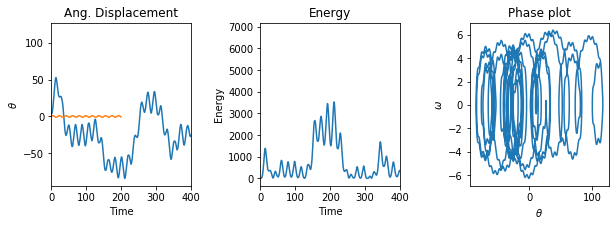

In [134]:
import matplotlib.pyplot as plt
import math as math

###########################
# for a periodic steady state, use q = 0.1, omega_D = 0.333, and 
# F_D = 0.4 or so.  
# To push it into the chaotic regime, increase F_D to 1.2 or more.
########################

dt = 0.05  # timestep
q = 0.1   # damping constant. uncomment for CHAOS BABY!
F_D = 1.4 # amplitude of the forcing term. uncomment for CHAOS WOO!
#q = 0
#F_D = 0
omega_D = 0.333 # 
theta0 = 3.141593/1.005

theta = []
omega = []
time = []
energy = []

theta.append(theta0)
omega.append(0.0)
time.append(0.0)

E = 0.5*theta[0]**2 + 0.5*omega[0]**2
energy.append(E)

imax = 10000
for i in range (1,imax):
    
    t_old = (i-1)*dt
    t_new = i*dt
    omega_new = omega[i-1] - math.sin(theta[i-1])*dt - q*omega[i-1]*dt + F_D*math.sin(omega_D*t_old)*dt
    theta_new = theta[i-1] + omega_new*dt
  
    
    E = 0.5*omega_new**2 + 0.5*theta_new**2
    
    theta.append(theta_new)
    omega.append(omega_new)
    energy.append(E)
    time.append(t_new)
    
x = np.linspace(0.0,200,2000)
y = np.sin(omega_D*x)

## Start with xlim = 100 to see the short time behavior. then increas in steps of 100
## to reveal the longer time behavior in the chaotic regime
plt.figure(1, figsize=(10, 3))
plt.subplots_adjust(wspace=0.5)
ax = plt.subplot(131)
ax.set_title('Ang. Displacement')
ax.set_xlabel('Time')
ax.set_ylabel('$\\theta$')
ax.set_xlim(right=400)
#ax.set_xlim(left=100)
plt.plot(time,theta)
plt.plot(x,y)

ax2 = plt.subplot(132)
ax2.set_title('Energy')
ax2.set_xlabel('Time')
ax2.set_xlim(right=400)
ax2.set_ylabel('Energy')
plt.plot(time,energy)

ax3 = plt.subplot(133)
ax3.set_title('Phase plot')
ax3.set_xlabel('$\\theta$')
ax3.set_ylabel('$\omega$')
plt.plot(theta,omega)
plt.show()


## Chaos baby! Yeah!

**Question:** For smaller amplitudes of the driving force, what is happening? Why does the system look nonperiodic for a few cycles, before settling down to periodic motion? What determines the frequency once it becomes periodic again?

For larger amplitudes of the driving force, however, we find altogether new behavior! It looks like the trajectory *never* repeats! 

**Question:** Does this mean that the trajectory of the pendulum is random? 

So we are left with something of a contradiction: On the one hand, the equation of motion is completely *deterministic* — for a given initial condition, the trajectory is fully determined. On the other hand, there seems to be a region of the parameter space that yields unpredictable-looking trajectories! (Go back and change the initial position of our pendulum slightly for the random-looking case.) wth is going on here?

Let's imagine we take two identical pendulums and set them in motion at the same time, but with slightly different initial angular displacements $\theta$. How does the difference in angular displacement between the two pendulums evolve in time? Is it constant? Does it get smaller or larger as time goes on? Labeling our pendulums by $a$ and $b$, we will define $\Delta\theta = |\theta_{b,i} - \theta_{a,i}|$. Notice that we take the difference in displacement at the same time. 

**Question:** For which case that we have studied above does $\Delta\theta$ remain constant?

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

###########################
# for a periodic steady state, use q = 0.1, omega_D = 0.333, and 
# F_D = 0.4 or so.  
# To push it into the chaotic regime, increase F_D to 1.2 or more.
########################

dt = 0.01  # timestep
q = 0.1   # damping constant
F_D = 0.2 # amplitude of the forcing term. try 1.2 for chaotic system. 0.2 for stable Lyapunov
# exponents
omega_D = 0.333 # 
theta0 = 3.141593/4.0

thetaA = []
thetaB = []
delta_theta = []
omegaA = []
omegaB = []
time = []
#energy = []

thetaA.append(theta0)
theta0 = theta0 + 0.001
thetaB.append(theta0)
dtheta = np.fabs(thetaA[0] - thetaB[0])
delta_theta.append(dtheta)

omegaA.append(0.0)
omegaB.append(0.0)
time.append(0.0)

#E = 0.5*theta[0]**2 + 0.5*omega[0]**2
#energy.append(E)

imax = 50000
for i in range (1,imax):
    
    t_old = (i-1)*dt
    t_new = i*dt

   
    omegaA_new = omegaA[i-1] - np.sin(thetaA[i-1])*dt - q*omegaA[i-1]*dt + F_D*np.sin(omega_D*t_old)*dt
    thetaA_new = thetaA[i-1] + omegaA_new*dt
    
    omegaB_new = omegaB[i-1] - np.sin(thetaB[i-1])*dt - q*omegaB[i-1]*dt + F_D*np.sin(omega_D*t_old)*dt
    thetaB_new = thetaB[i-1] + omegaB_new*dt
  
    
    
    thetaA.append(thetaA_new)
    omegaA.append(omegaA_new)
    thetaB.append(thetaB_new)
    omegaB.append(omegaB_new)
    
    dtheta = np.fabs(thetaA[i] - thetaB[i])
    delta_theta.append(dtheta)
 
    time.append(t_new)


## Start with xlim = 100 to see the short time behavior. then increas in steps of 100
## to reveal the longer time behavior in the chaotic regime
plt.figure(1, figsize=(10, 3))
plt.subplots_adjust(wspace=0.5)
ax = plt.subplot(131)
ax.set_title('Ang. Displacement')
ax.set_xlabel('Time')
ax.set_ylabel('$\\theta$')
ax.set_xlim(right=24)
plt.plot(time,thetaA)
plt.plot(time, thetaB)


## just a little calc so that we can add an exponential to the middle 
## plot in order to demonstrate the Lyapunov exponent
#
## 0.004*exp(-0.05*x) works for the stable trajectory (FD = 0.4)
##  0.0001*exp(0.2*x) works for FD = 1.2
x = np.linspace(0.0,400,400)
y = 0.0001*(np.exp(0.2*x))  ## 0.005*exp(-0.05x) for the nonchaotic trajectory
# and 0.0001*exp(0.2*x) for the chaotic one

## Mess around with the scale of the y axis to show the exponential 
## behvior of delta theta: toggle back and forth by uncommenting the log scale line
ax2 = plt.subplot(132)
ax2.set_title('Delta theta')
ax2.set_xlabel('Time')
ax2.set_ylabel('$\Delta\\theta$')
plt.yscale("log")
ax2.set_xlim(right=100)
ax2.set_ylim(top=10)
ax2.set_ylim(bottom=0.0000001)
plt.plot(time,delta_theta)
#plt.plot(x,y) #uncomment to show the Lyapunov exponent


ax3 = plt.subplot(133)
ax3.set_title('Phase plot')
ax3.set_xlabel('$\\theta$')
ax3.set_ylabel('$\omega$')
plt.plot(thetaA,omegaA)
plt.show()


**Stability limits and Lyapunov exponent:** Our analysis of $\Delta\theta$ shows that we can switch the behavior from stable to unstable by changing the strength of the driving force. For smaller values of $F_D$, $\Delta\theta \rightarrow 0$ with increasing time. On the other hand, $\Delta\theta$ diverges with time for larger values of $F_D$. Notice that in both cases the dependence of $\Delta\theta$ on $t$ looks to be *exponential* — when we plot it with a logarithmic scale in y, $\Delta\theta$ follows a striaght line (on average). 

So, even though the behavior is chaotic, it is describable. The exponent that appears in the fit to an exponential is called the Lyapunov exponent, denoted $\lambda$, and it tells us how sensitively the system depends on its initial conditions. Positive $\lambda$, and the trajectory will diverge exponentially from a nearby one — this is the chaotic regime. Larger positive $\lambda$, faster divergence. If $\lambda < 0$, however, the systems settles down to a steady oscillation at the frequency of the driving force. $\lambda = 0$ therefore separates the stable and unstable regimes.

In fact, we can identify even more structure in the chaotic trajectory of our pendulum, by looking at the trajectory in the $\theta - \omega$ phase space. In order to facilitate the analysis, we will wrap $\theta$ back into the interval $[-\pi...\pi]$, since it is periodic, after all.

First, we will look for structure in the phase plot, introducing a trick called a **Poincare section.** Next we will ask how our system switches from nice, niormal, periodic behavior to CHAOS. This occurs through something called **period doubling.**

In [ ]:
import matplotlib.pyplot as plt
import math as math

###########################
# for a periodic steady state, use q = 0.1, omega_D = 0.666 (switched here to match
# Girodano), and F_D = 0.4 or so.  
# To push it into the chaotic regime, increase F_D to 1.2 or more.
########################

dt = 0.05  # timestep
q = 0.1   # damping constant
F_D = 0.2 # amplitude of the forcing term. 0.2 for stable, 1.2 for unstable
omega_D = 0.666 # 
theta0 = 0.2

theta = []
theta_mod = []
omega = []
time = []

theta.append(theta0)
theta_mod.append(theta0)
omega.append(0.0)
time.append(0.0)



imax = 100000
for i in range (1,imax):
    
    t_old = (i-1)*dt
    t_new = i*dt
    omega_new = omega[i-1] - math.sin(theta[i-1])*dt - q*omega[i-1]*dt + F_D*math.sin(omega_D*t_old)*dt
    theta_new = theta[i-1] + omega_new*dt
    
    two_pi = 2.0*math.pi
    pi = math.pi
    if theta_new > 0:
        tmp = theta_new + pi
        mod = math.fmod(tmp,two_pi) - pi
    else:
        tmp = theta_new - pi
        mod = math.fmod(tmp,two_pi) + pi
  
    theta.append(theta_new)
    theta_mod.append(mod)
    omega.append(omega_new)
    #energy.append(E)
    time.append(t_new)



plt.figure(1, figsize=(8.5, 4))
plt.subplots_adjust(wspace=0.5)
ax = plt.subplot(121)
ax.set_title('Ang. Displacement')
ax.set_xlabel('Time')
ax.set_ylabel('$\\theta$')
ax.set_xlim(right=500)
#ax.set_ylim(top=5,bottom=-5)
#plt.plot(time,theta)
plt.plot(time,theta_mod)


ax3 = plt.subplot(122)
ax3.set_title('Phase plot')
ax3.set_xlabel('$\\theta$')
ax3.set_ylabel('$\omega$')
plt.plot(theta_mod,omega)
plt.show()


Notice the structure in the phase plot. For stable trajectories, the phase plot settles down to repeating orbit after the initial transient. Unstable trajectories, however, display a much richer behavior: there seem to be almost stable orbits that are returned to on occasion, but not quite exactly. How might we determine whether this is actually the case, amidst the mess that is the chaotic phase space plot?

The trick is to *subsample* the trajectory, and only look at phase space points at particular times. But what times? Well, the only other timescale in the problem is that of the driving force. So let's try only plotting points that land on times that are integer multiples of the driving frequency. 

In [ ]:
import matplotlib.pyplot as plt
import math as math

###########################
# for a periodic steady state, use q = 0.1, omega_D = 0.333, and 
# F_D = 0.4 or so.  
# To push it into the chaotic regime, increase F_D to 1.2 or more.
########################

dt = 0.01  # timestep
q = 0.5   # damping constant
F_D = 1.2 # amplitude of the forcing term
omega_D = 0.6666 # 
theta0 = 0.2

theta = []
theta_mod = []
omega = []
time = []
theta_sub = []
omega_sub = []

theta.append(theta0)
theta_mod.append(theta0)
omega.append(0.0)
time.append(0.0)



imax = 500000
for i in range (1,imax):
    
    t_old = (i-1)*dt
    t_new = i*dt
    omega_new = omega[i-1] - math.sin(theta[i-1])*dt - q*omega[i-1]*dt + F_D*math.sin(omega_D*t_old)*dt
    theta_new = theta[i-1] + omega_new*dt
    
    ## wrap theta into the domain [-pi...pi]
    two_pi = 2.0*math.pi
    pi = math.pi
    if theta_new > 0:
        tmp = theta_new + pi
        mod = math.fmod(tmp,two_pi) - pi
    else:
        tmp = theta_new - pi
        mod = math.fmod(tmp,two_pi) + pi
  
    theta.append(theta_new)
    theta_mod.append(mod)
    omega.append(omega_new)
    time.append(t_new)
    
    # only look at times that are in phase with the driving force
    index_time = two_pi/omega_D
    time_mod = math.fmod(t_new,index_time)
    if time_mod < dt:
        theta_sub.append(mod)
        omega_sub.append(omega_new)


## Start with xlim = 100 to see the short time behavior. then increas in steps of 100
## to reveal the longer time behavior in the chaotic regime
plt.figure(1, figsize=(8.5, 4))
plt.subplots_adjust(wspace=0.5)
ax1 = plt.subplot(121)
ax1.set_title('Phase plot: Poincare')
ax1.set_xlabel('$\\theta$')
ax1.set_ylabel('$\omega$')
#ax1.set_aspect("equal")
plt.scatter(theta_sub,omega_sub, marker=".", s=1.5)

ax2 = plt.subplot(122)
ax2.set_title('Phase plot')
ax2.set_xlabel('$\\theta$')
ax2.set_ylabel('$\omega$')
plt.plot(theta_mod,omega)

plt.show()





Aha! We see that there are indeed nearly stable orbits hidden within the mess of the phase plot. By only selecting points that are in phase with the driving force, we are doing something like watching a ceiling fan illuminated by a strobe light. If the frequency of the strobe and the fan are equal, the fan appears to stand still, even though it is moving, because every time you observe it it, it happens to be in the same location. The object that we obtain by selecting the phase space points that correspond to the driving frequency is called a "Poincare section."

Of course, the orbit is not perfectly closed (if it were, it would be a stable, repeating orbit), and so our Poincare section looks a little fuzzy. That is not a numerical innacuracy — the structure of chaotic Poincare sections is fractal, and they are known as "strange attractors." Regular motion also has attractors, they are just not very strange!

**Question:** What would a Poincare section look like if you made one for a regular old boring pendulum (no chaos)?

## How does a system switch from regular motion to chaotic? 

We have seen so far that the trajectory of our pendulum can be chaotic or not, depending on the strength of the driving force. But how does the system go from regular to chaotic? Is it a sharp transition? What happens right before? This is a perfect question for numerical simulation! All we have to do is look at how our pendulum behaves as we vary the driving force.

In [ ]:
import matplotlib.pyplot as plt
import math as math
import time as time_lib
from IPython import display

###########################
# for a periodic steady state, use q = 0.1, omega_D = 0.666, and 
# F_D = 0.2 or so.  
# To push it into the chaotic regime, increase F_D to 1.2 or more.
########################

dt = 0.05  # timestep
q = 0.5   # damping constant
F_D = 1.0 # amplitude of the forcing term
omega_D = 0.666 # 
theta0 = 0.2

theta = []
theta_mod = []
omega = []
time = []

theta.append(theta0)
theta_mod.append(theta0)
omega.append(0.0)
time.append(0.0)

## Start with xlim = 100 to see the short time behavior. then increas in steps of 100
## to reveal the longer time behavior in the chaotic regime


dF = 0.01
for j in range (1,50):
    F_D = F_D + dF
    
    theta = []
    theta_mod = []
    omega = []
    time = []

    theta.append(theta0)
    theta_mod.append(theta0)
    omega.append(0.0)
    time.append(0.0)
    
    imax = 2000
    for i in range (1,imax):
    
        t_old = (i-1)*dt
        t_new = i*dt
    
        omega_new = omega[i-1] - math.sin(theta[i-1])*dt - q*omega[i-1]*dt + F_D*math.sin(omega_D*t_old)*dt
        theta_new = theta[i-1] + omega_new*dt
    
        two_pi = 2.0*math.pi
        pi = math.pi
        if theta_new > 0:
            tmp = theta_new + pi
            mod = math.fmod(tmp,two_pi) - pi
        else:
            tmp = theta_new - pi
            mod = math.fmod(tmp,two_pi) + pi
  
        theta.append(theta_new)
        theta_mod.append(mod)
        omega.append(omega_new)
        #energy.append(E)
        time.append(t_new)
        
    plt.clf()
    plt.plot(time,theta_mod)
    display.clear_output(wait=False)
    display.display(plt.gcf())
    time_lib.sleep(1.0)
## Start with xlim = 100 to see the short time behavior. then increas in steps of 100
## to reveal the longer time behavior in the chaotic regime
    #plt.figure(1, figsize=(8.5, 4))
    #plt.subplots_adjust(wspace=0.5)
    #ax = plt.subplot(121)
    #ax.set_title('Ang. Displacement')
    #ax.set_xlabel('Time')
    #ax.set_ylabel('$\\theta$')
    #ax.set_xlim(right=100)
#ax.set_ylim(top=5,bottom=-5)
    
    
    #ax.clear()
    #ax.plot(time,theta)
    #fig.canvas.draw()
    #plt.plot(time,theta)
    #plt.show()
    #time_lib.sleep(1)
    #plt.cla()
    #plot1.plot(time,theta_mod)
    #plot1.show()
    #time_lib.sleep(1)
    #plot1.clear()

#ax3 = plt.subplot(122)
#ax3.set_title('Phase plot')
#ax3.set_xlabel('$\\theta$')
#ax3.set_ylabel('$\omega$')
#plt.plot(theta_mod,omega)
    #plt.show()
    #time_lib.sleep(1)
   


Notice what happens to the period as we increase $F_D$. At some well-defined value of $F_D$ the period of the signal *doubles* — i.e., you have to wait twice as long for the pattern to repeat. Increase $F_D$ a bit more, and the period doubles again. And then again, and so on, until the system is chaotic, and the trajectory *never* repeats itself — the period becomes infinite. 

Do other dynamical systems show this same period-doubling behavior in the transition from regular to chaotic motion? Is there anything *universal* about the transition to chaos, that is, are there features of thje transition that are independent of the detailed physics of the model? Indeed, the answer to both of these questions is yes, but in order to uncover these universal features we need a plot which summarizes the period doubling behavior. For this, we turn to the **bifurcation diagram.**

## Bifurcation Diagram

Because the signature of approaching chaos is the period of oscillation doubling, and doubling again, and again, let's plot the position of the pendulum at integer multiples of the driving force period. When the peropds are equal, we get one point (returns to the same place each period); when the period of the pendulum is twice the driving force, then we get two points, etc. This is an example of a bifurcation diagram.


In [ ]:
import matplotlib.pyplot as plt
import math as math

###########################
# for a periodic steady state, use q = 0.1, omega_D = 0.666, and 
# F_D = 0.2 or so.  
# To push it into the chaotic regime, increase F_D to 1.2 or more.
########################

dt = 0.05  # timestep
q = 0.5   # damping constant
F_D = 1.0 # amplitude of the forcing term
omega_D = 0.666 # 
theta0 = 0.2
F_period = 2.0*math.pi/omega_D
discard = 300.0*F_period

theta = []
theta_mod = []
omega = []
time = []
bif_diagram = []
F_D_array = []

theta.append(theta0)
theta_mod.append(theta0)
omega.append(0.0)
time.append(0.0)

# for good resolution and range in the F_D param, use dF = 0.01 and j in range(1,50)
dF = 0.1
for j in range (1,10):
    F_D = F_D + dF
    
    theta = []
    theta_mod = []
    omega = []
    time = []

    theta.append(theta0)
    theta_mod.append(theta0)
    omega.append(0.0)
    time.append(0.0)
    
    imax = 80000
    #use imax = 80000 to get enough periods for bifurcation diagram
    for i in range (1,imax):
    
        t_old = (i-1)*dt
        t_new = i*dt
    
        omega_new = omega[i-1] - math.sin(theta[i-1])*dt - q*omega[i-1]*dt + F_D*math.sin(omega_D*t_old)*dt
        theta_new = theta[i-1] + omega_new*dt
    
        two_pi = 2.0*math.pi
        pi = math.pi
        if theta_new > 0:
            tmp = theta_new + pi
            mod = math.fmod(tmp,two_pi) - pi
        else:
            tmp = theta_new - pi
            mod = math.fmod(tmp,two_pi) + pi
            
        tmp2 = math.fmod(t_new,F_period)
        
        
        if tmp2 <= 0.002 and t_new > discard:
            #print(tmp2, t_new)
            F_D_array.append(F_D)
            bif_diagram.append(mod)
  
        theta.append(theta_new)
        theta_mod.append(mod)
        omega.append(omega_new)
        time.append(t_new)

plt.scatter(F_D_array,bif_diagram)


well shit, that's not working...but here's what it's supposed to look like (Giordano, Fig. 3.11): <img src="./giordano_bif_plot.png" alt="bif_diagram" width="300"/>

Using "numerical experiments" (in the quaint language of the 60's) we are starting to see how the transition to chaos comes about. But is there anything universal in the transition to chaos? Let's consider the following quantity:

$$\delta_n \equiv \frac{F_n-F_{n-1}}{F_{n+1}-F_n} $$

where $F_n$ is the forcing amplitude that marks the onset of the $n^{\text{th}}$ period doubling. Remarkably, as $n \rightarrow \infty$, $\delta$ approaches a limiting value of $4.6692...$. Even more remarkably, *every dynamical system* which satisfies a very simple property (discussed later) has the *same* value for this constant. This is what we mean by "universal." 

This was first shown by Mitchell Feigenbaum in 1976[^1] for a simple dynamical system called the logistic map (also discussed below). A mathematical proof was only provided in $1999$. It is held, but not proven, that the value of $\delta$ is transcendental. 

**Question:** What is a transcendental number? Irrational number? Rational number? Are irrational and/or transcendental numbers normal to every base?

But we still have not determined *why* some systems display period doubling and eventually chaos, and others do not. To explore this issue, we turn to a stripped down discrete model called the "logistic map."

[^1]: Feigenbaum, M. "Universality in complex discrete dynamnics" Los Alamos Theoretical Division Annual Report 1975-1976